In [1]:
# import apriltag
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import glob
import os
import time
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as scipy_R

In [2]:
%matplotlib inline

In [3]:
data_root = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image'

In [4]:
def get_RT_world_from_rtvec(_rvec=[.0,.0,.0], _tvec=[.0,.0,.0]):
    _R_c, _ = cv2.Rodrigues(_rvec)
    _R_w = _R_c.transpose()
    _T_c = _tvec
    _T_w = -np.matmul(_R_w, _T_c)
    return _R_w, _T_w

In [11]:
def get_RT_trans_from_serial(_data_root, _left_serial, _right_serial):
    _prefix = 'left_' + _left_serial + '_right_' + _right_serial
    _stereo_root = os.path.join(_data_root, 'extrinsic_images_checker', _prefix)
    _rvec_cam = np.load(os.path.join(_stereo_root, 'left_' + _left_serial + '_right_' + _right_serial+'_rvec.npy'))
    _tvec_cam = np.load(os.path.join(_stereo_root, 'left_' + _left_serial + '_right_' + _right_serial+'_tvec.npy'))

    R_trans_world_left_to_right, T_trans_world_left_to_right = get_RT_world_from_rtvec(_rvec_cam, _tvec_cam)

    return R_trans_world_left_to_right, T_trans_world_left_to_right

In [12]:
cam_serial_list = ['22240376', '22206080', '22240368', '22240389', '22222961', '22240382']

R_trans_world_0_1, T_trans_world_0_1 = get_RT_trans_from_serial(data_root, cam_serial_list[0], cam_serial_list[1])
R_trans_world_1_2, T_trans_world_1_2 = get_RT_trans_from_serial(data_root, cam_serial_list[1], cam_serial_list[2])
R_trans_world_2_3, T_trans_world_2_3 = get_RT_trans_from_serial(data_root, cam_serial_list[2], cam_serial_list[3])
R_trans_world_3_4, T_trans_world_3_4 = get_RT_trans_from_serial(data_root, cam_serial_list[3], cam_serial_list[4])
R_trans_world_4_5, T_trans_world_4_5 = get_RT_trans_from_serial(data_root, cam_serial_list[4], cam_serial_list[5])
R_trans_world_5_0, T_trans_world_5_0 = get_RT_trans_from_serial(data_root, cam_serial_list[5], cam_serial_list[0])

In [13]:
data_root

'/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image'

In [14]:
is_old = False

mtx_list = []
dist_list = []
for cam_serial in cam_serial_list:
    _npz_file = np.load(os.path.join(data_root, cam_serial + '_intrinsic_result.npz'))
    _mtx = _npz_file['mtx']
    _dist = _npz_file['dist']
    mtx_list.append(_mtx)
    dist_list.append(_dist)


In [15]:
R_world_cam_0 = np.identity(3)
T_world_cam_0 = np.zeros([3,1])

R_world_cam_1 = np.matmul(R_world_cam_0, R_trans_world_0_1)
T_world_cam_1 = T_world_cam_0 + np.matmul(R_world_cam_0, T_trans_world_0_1)

R_world_cam_2 = np.matmul(R_world_cam_1, R_trans_world_1_2)
T_world_cam_2 = T_world_cam_1 + np.matmul(R_world_cam_1, T_trans_world_1_2)

R_world_cam_3 = np.matmul(R_world_cam_2, R_trans_world_2_3)
T_world_cam_3 = T_world_cam_2 + np.matmul(R_world_cam_2, T_trans_world_2_3)

R_world_cam_4 = np.matmul(R_world_cam_3, R_trans_world_3_4)
T_world_cam_4 = T_world_cam_3 + np.matmul(R_world_cam_3, T_trans_world_3_4)

R_world_cam_5 = np.matmul(R_world_cam_4, R_trans_world_4_5)
T_world_cam_5 = T_world_cam_4 + np.matmul(R_world_cam_4, T_trans_world_4_5)

R_world_cam_0_loop = np.matmul(R_world_cam_5, R_trans_world_5_0)
T_world_cam_0_loop = T_world_cam_5 + np.matmul(R_world_cam_5, T_trans_world_5_0)

In [16]:
print(R_world_cam_0_loop)
print(T_world_cam_0_loop)

[[ 9.99983890e-01 -4.50152103e-04 -5.65842537e-03]
 [ 4.70909146e-04  9.99993164e-01  3.66754584e-03]
 [ 5.65673574e-03 -3.67015136e-03  9.99977265e-01]]
[[ 23.29900961]
 [  6.75975401]
 [-16.63405615]]


In [17]:
def from_world_to_cam_coord(_R_w, _T_w):
    _R_cam = _R_w.transpose()
    _T_cam = -np.matmul(_R_cam, _T_w)
    _r_scipy = scipy_R.from_matrix(_R_cam)
    _rvec = _r_scipy.as_rotvec().reshape(3,1)
    _tvec = _T_cam.reshape(3,1)
    return _rvec, _tvec

def calculate_Tr(K_np, rvec_np, tvec_np):
    _R_cv2bcam = np.array([[1,0,0],
                       [0,-1,0],
                       [0,0,-1]])
    R, _ = cv2.Rodrigues(rvec_np)
    # t = tvec_np[_i]/100. #(mm to M)? scale problem exist.
    t = tvec_np/100. #(mm to M)? scale problem exist.
    # k = first_K_np
    R_bcam= np.matmul(_R_cv2bcam, R)
    T_bcam = np.matmul(_R_cv2bcam, t)                       
    R_world = R_bcam.transpose()
    T_world = -np.matmul(R_world, T_bcam)

    R_world = R_world.reshape(3,3)
    T_world = T_world.reshape(3,1)

    Tr = np.identity(4)
    Tr[:3,:3] = R_world
    Tr[:3,3:] = T_world

    return Tr

In [18]:
rvec_cam_0, tvec_cam_0 = from_world_to_cam_coord(R_world_cam_0, T_world_cam_0)
rvec_cam_1, tvec_cam_1 = from_world_to_cam_coord(R_world_cam_1, T_world_cam_1)
rvec_cam_2, tvec_cam_2 = from_world_to_cam_coord(R_world_cam_2, T_world_cam_2)
rvec_cam_3, tvec_cam_3 = from_world_to_cam_coord(R_world_cam_3, T_world_cam_3)
rvec_cam_4, tvec_cam_4 = from_world_to_cam_coord(R_world_cam_4, T_world_cam_4)
rvec_cam_5, tvec_cam_5 = from_world_to_cam_coord(R_world_cam_5, T_world_cam_5)


In [19]:
rvec_cam_list = []
tvec_cam_list = []

rvec_cam_list.append(rvec_cam_0)
tvec_cam_list.append(tvec_cam_0)
rvec_cam_list.append(rvec_cam_1)
tvec_cam_list.append(tvec_cam_1)
rvec_cam_list.append(rvec_cam_2)
tvec_cam_list.append(tvec_cam_2)
rvec_cam_list.append(rvec_cam_3)
tvec_cam_list.append(tvec_cam_3)
rvec_cam_list.append(rvec_cam_4)
tvec_cam_list.append(tvec_cam_4)
rvec_cam_list.append(rvec_cam_5)
tvec_cam_list.append(tvec_cam_5)


In [20]:
# Tr_trans_0 = calculate_Tr(K_np=None, rvec_np=rvec_cam_0, tvec_np=tvec_cam_0) # zeros.
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[0]+'_Tr.npy'), Tr_trans_0)

# Tr_trans_1 = calculate_Tr(K_np=None, rvec_np=rvec_cam_1, tvec_np=tvec_cam_1)
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[1]+'_Tr.npy'), Tr_trans_1)

# Tr_trans_2 = calculate_Tr(K_np=None, rvec_np=rvec_cam_2, tvec_np=tvec_cam_2)
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[2]+'_Tr.npy'), Tr_trans_2)

# Tr_trans_3 = calculate_Tr(K_np=None, rvec_np=rvec_cam_3, tvec_np=tvec_cam_3)
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[3]+'_Tr.npy'), Tr_trans_3)

# Tr_trans_4 = calculate_Tr(K_np=None, rvec_np=rvec_cam_4, tvec_np=tvec_cam_4)
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[4]+'_Tr.npy'), Tr_trans_4)

# Tr_trans_5 = calculate_Tr(K_np=None, rvec_np=rvec_cam_5, tvec_np=tvec_cam_5)
# np.save(os.path.join(data_root, 'extrinsic_images', cam_serial_list[5]+'_Tr.npy'), Tr_trans_5)

In [21]:
def get_K(_params):
    K = np.zeros((3,3))
    K[0,0] = _params[0]
    K[1,1] = _params[1]
    K[0,2] = _params[2]
    K[1,2] = _params[3]
    K[2,2] = 1.
    return K

In [22]:
def distance_calculator(_rvec_cam_left, _tvec_cam_left, _rvec_cam_right, _tvec_cam_right, _april_objpoints, _left_april_imgpoints, _right_april_imgpoints, _left_mtx, _left_dist, _right_mtx, _right_dist):
    distance_holder = []
    for i in range(len(_april_objpoints)):
        left_success, left_rvec, left_tvec = cv2.solvePnP(_april_objpoints[i], _left_april_imgpoints[i], _left_mtx, _left_dist, 0)
        left_R = cv2.Rodrigues(left_rvec)[0]
        right_success, right_rvec, right_tvec = cv2.solvePnP(_april_objpoints[i], _right_april_imgpoints[i], _right_mtx, _right_dist, 0)
        right_R = cv2.Rodrigues(right_rvec)[0]

        # left_detected_imgpoints = _left_april_imgpoints[i].reshape(-1, 2)
        # right_detected_imgpoints = _right_april_imgpoints[i].reshape(-1, 2)

        left_object_points = (left_R.dot(_april_objpoints[i].T) + left_tvec).T # N, 3
        right_object_points = (right_R.dot(_april_objpoints[i].T) + right_tvec).T # N, 3

        R_cam_left = cv2.Rodrigues(_rvec_cam_left)[0]
        left_object_points = R_cam_left.T.dot(left_object_points.T - _tvec_cam_left).T

        R_cam_right = cv2.Rodrigues(_rvec_cam_right)[0]
        right_object_points = R_cam_right.T.dot(right_object_points.T - _tvec_cam_right).T

        assert left_object_points.shape == right_object_points.shape

        distance = np.mean(np.linalg.norm(left_object_points - right_object_points, axis=1))

        distance_holder.append(distance)
    return np.mean(distance_holder)

In [23]:
def fun(parameters, _april_objpoints, _left_april_imgpoints, _right_april_imgpoints):
    rvec_cam_left = parameters[:3].reshape(3,1)
    tvec_cam_left = parameters[3:6].reshape(3,1)
    rvec_cam_right = parameters[6:9].reshape(3,1)
    tvec_cam_right = parameters[9:12].reshape(3,1)
    left_mtx = get_K(parameters[12:16])
    left_dist = parameters[16:21].reshape(1,5)
    right_mtx = get_K(parameters[21:25])
    right_dist = parameters[25:30].reshape(1,5)
    
    return distance_calculator(rvec_cam_left, tvec_cam_left, rvec_cam_right, tvec_cam_right, _april_objpoints, _left_april_imgpoints, _right_april_imgpoints, left_mtx, left_dist, right_mtx, right_dist)
    

# LOAD 3D Points

In [24]:
import pickle

In [19]:
# def load_point3d_structure(_left_serial, _right_serial):
#     # left_serial = cam_serial_list[0]
#     # right_serial = cam_serial_list[1]
#     _prefix = 'left_' + _left_serial + '_right_' + _right_serial
#     _stereo_root = os.path.join(data_root, 'extrinsic_images', _prefix)
#     print(os.path.join(_stereo_root, 'point3d_structure.pkl'))
#     point3d_structure = pickle.load(open(os.path.join(_stereo_root, 'point3d_structure.pkl'), 'rb'))
    
#     return point3d_structure

In [20]:
# point3d_structure_0_1 = load_point3d_structure(cam_serial_list[0], cam_serial_list[1])
# point3d_structure_1_2 = load_point3d_structure(cam_serial_list[1], cam_serial_list[2])
# point3d_structure_2_3 = load_point3d_structure(cam_serial_list[2], cam_serial_list[3])
# point3d_structure_3_4 = load_point3d_structure(cam_serial_list[3], cam_serial_list[4])
# point3d_structure_4_5 = load_point3d_structure(cam_serial_list[4], cam_serial_list[5])
# point3d_structure_5_0 = load_point3d_structure(cam_serial_list[5], cam_serial_list[0])

/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22240376_right_22206080/point3d_structure.pkl
/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22206080_right_22240368/point3d_structure.pkl
/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22240368_right_22240389/point3d_structure.pkl
/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22240389_right_22222961/point3d_structure.pkl
/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22222961_right_22240382/point3d_structure.pkl
/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22240382_right_22240376/point3d_structure.pkl


In [21]:
# point3d_structure_list = [point3d_structure_0_1, point3d_structure_1_2, point3d_structure_2_3, point3d_structure_3_4, point3d_structure_4_5, point3d_structure_5_0]

In [24]:
# left_img_name_list_all = []
# right_img_name_list_all = []
# april_objpoints_list_all = []
# left_april_imgpoints_list_all = []
# right_april_imgpoints_list_all = []

# for i in range(len(point3d_structure_list)):

#     left_img_name_list = []
#     right_img_name_list = []
#     april_objpoints_list = []
#     left_april_imgpoints_list = []
#     right_april_imgpoints_list = []

#     for smaple_i in range(len(point3d_structure_list[i])):
#         left_img_name = point3d_structure_list[i][smaple_i]['left_img_name']
#         right_img_name = point3d_structure_list[i][smaple_i]['right_img_name']
#         april_objpoints = point3d_structure_list[i][smaple_i]['april_objpoints']
#         left_detected_imgpoints = point3d_structure_list[i][smaple_i]['left_detected_imgpoints']
#         right_detected_imgpoints = point3d_structure_list[i][smaple_i]['right_detected_imgpoints']
#         left_img_name_list.append(left_img_name)
#         right_img_name_list.append(right_img_name)
#         april_objpoints_list.append(april_objpoints)
#         left_april_imgpoints_list.append(left_detected_imgpoints)
#         right_april_imgpoints_list.append(right_detected_imgpoints)

#     left_img_name_list_all.append(left_img_name_list)
#     right_img_name_list_all.append(right_img_name_list)
#     april_objpoints_list_all.append(april_objpoints_list)
#     left_april_imgpoints_list_all.append(left_april_imgpoints_list)
#     right_april_imgpoints_list_all.append(right_april_imgpoints_list)
    
    

In [28]:
# np.savez(save_dir, april_objpoints=april_objpoints, left_april_imgpoints=left_april_imgpoints, right_april_imgpoints=right_april_imgpoints, april_imagename=april_imagename)
calibration_data_0_1 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[0] + '_right_' + cam_serial_list[1], 'calibration_data.npz'))
calibration_data_1_2 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[1] + '_right_' + cam_serial_list[2], 'calibration_data.npz'))
calibration_data_2_3 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[2] + '_right_' + cam_serial_list[3], 'calibration_data.npz'))
calibration_data_3_4 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[3] + '_right_' + cam_serial_list[4], 'calibration_data.npz'))
calibration_data_4_5 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[4] + '_right_' + cam_serial_list[5], 'calibration_data.npz'))
calibration_data_5_0 = np.load(os.path.join(data_root, 'extrinsic_images_checker', 'left_' + cam_serial_list[5] + '_right_' + cam_serial_list[0], 'calibration_data.npz'))

In [30]:
april_objpoints_list_all = []
left_april_imgpoints_list_all = []
right_april_imgpoints_list_all = []


april_objpoints_list_all.append(calibration_data_0_1['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_0_1['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_0_1['right_april_imgpoints'])

april_objpoints_list_all.append(calibration_data_1_2['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_1_2['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_1_2['right_april_imgpoints'])

april_objpoints_list_all.append(calibration_data_2_3['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_2_3['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_2_3['right_april_imgpoints'])

april_objpoints_list_all.append(calibration_data_3_4['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_3_4['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_3_4['right_april_imgpoints'])

april_objpoints_list_all.append(calibration_data_4_5['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_4_5['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_4_5['right_april_imgpoints'])

april_objpoints_list_all.append(calibration_data_5_0['april_objpoints'])
left_april_imgpoints_list_all.append(calibration_data_5_0['left_april_imgpoints'])
right_april_imgpoints_list_all.append(calibration_data_5_0['right_april_imgpoints'])


In [31]:
# x0 = make_x0(rvec_cam_0, tvec_cam_0, rvec_cam_1, tvec_cam_1, rvec_cam_2, tvec_cam_2, rvec_cam_3, tvec_cam_3, rvec_cam_4, tvec_cam_4, rvec_cam_5, tvec_cam_5)
def make_x0(_rvec_cam_list, _tvec_cam_list, _mtx_list, _dist_list):
    assert(len(_rvec_cam_list) == len(_tvec_cam_list) == len(_mtx_list) == len(_dist_list)), 'length of rvec_cam_list, tvec_cam_list, mtx_list, dist_list should be equal'
    num_cams = len(_rvec_cam_list)
    x0 = np.concatenate([_rvec_cam_list, _tvec_cam_list], axis=1)
    x0 = x0.reshape(-1)

    for i in range(num_cams):
        # x0 = np.concatenate([x0, _mtx_list[i].flatten(), _dist_list[i].flatten()])
        x0 = np.concatenate([x0, np.array([_mtx_list[i][0,0], _mtx_list[i][1,1], _mtx_list[i][0,2], _mtx_list[i][1,2]]).flatten()])
        x0 = np.concatenate([x0, _dist_list[i].flatten()])
    
    return x0, num_cams

In [32]:
x0, num_cam = make_x0(rvec_cam_list, tvec_cam_list, mtx_list, dist_list)

In [33]:
len(x0) # 6*6 + 9*6

90

In [34]:
def fun_all_camera(parameters, _april_objpoints_all, _left_april_imgpoints_all, _right_april_imgpoints_all, no_distortion=False):

    # no_distortion = True

    rvec_cam_0 = parameters[:3].reshape(3,1)
    tvec_cam_0 = parameters[3:6].reshape(3,1)

    rvec_cam_0 = np.zeros([3,1])
    tvec_cam_0 = np.zeros([3,1]) # FIX FIRST CAMERA IDENTITY

    rvec_cam_1 = parameters[6:9].reshape(3,1)
    tvec_cam_1 = parameters[9:12].reshape(3,1)
    rvec_cam_2 = parameters[12:15].reshape(3,1)
    tvec_cam_2 = parameters[15:18].reshape(3,1)
    rvec_cam_3 = parameters[18:21].reshape(3,1)
    tvec_cam_3 = parameters[21:24].reshape(3,1)
    rvec_cam_4 = parameters[24:27].reshape(3,1)
    tvec_cam_4 = parameters[27:30].reshape(3,1)
    rvec_cam_5 = parameters[30:33].reshape(3,1)
    tvec_cam_5 = parameters[33:36].reshape(3,1)
    mtx_0 = get_K(parameters[36:40])
    dist_0 = parameters[40:45].reshape(1,5)
    mtx_1 = get_K(parameters[45:49])
    dist_1 = parameters[49:54].reshape(1,5)
    mtx_2 = get_K(parameters[54:58])
    dist_2 = parameters[58:63].reshape(1,5)
    mtx_3 = get_K(parameters[63:67])
    dist_3 = parameters[67:72].reshape(1,5)
    dist_3 = np.zeros([1,5])
    mtx_4 = get_K(parameters[72:76])
    dist_4 = parameters[76:81].reshape(1,5)
    dist_4 = np.zeros([1,5])
    mtx_5 = get_K(parameters[81:85])
    dist_5 = parameters[85:90].reshape(1,5)
    dist_5 = np.zeros([1,5])

    if no_distortion:
        dist_0 = np.zeros([1,5])
        dist_1 = np.zeros([1,5])
        dist_2 = np.zeros([1,5])
        dist_3 = np.zeros([1,5])
        dist_4 = np.zeros([1,5])
        dist_5 = np.zeros([1,5])

    distance_0_1 = distance_calculator(rvec_cam_0, tvec_cam_0, rvec_cam_1, tvec_cam_1, _april_objpoints_all[0], _left_april_imgpoints_all[0], _right_april_imgpoints_all[0], mtx_0, dist_0, mtx_1, dist_1)
    distance_1_2 = distance_calculator(rvec_cam_1, tvec_cam_1, rvec_cam_2, tvec_cam_2, _april_objpoints_all[1], _left_april_imgpoints_all[1], _right_april_imgpoints_all[1], mtx_1, dist_1, mtx_2, dist_2)
    distance_2_3 = distance_calculator(rvec_cam_2, tvec_cam_2, rvec_cam_3, tvec_cam_3, _april_objpoints_all[2], _left_april_imgpoints_all[2], _right_april_imgpoints_all[2], mtx_2, dist_2, mtx_3, dist_3)
    distance_3_4 = distance_calculator(rvec_cam_3, tvec_cam_3, rvec_cam_4, tvec_cam_4, _april_objpoints_all[3], _left_april_imgpoints_all[3], _right_april_imgpoints_all[3], mtx_3, dist_3, mtx_4, dist_4)
    distance_4_5 = distance_calculator(rvec_cam_4, tvec_cam_4, rvec_cam_5, tvec_cam_5, _april_objpoints_all[4], _left_april_imgpoints_all[4], _right_april_imgpoints_all[4], mtx_4, dist_4, mtx_5, dist_5)
    distance_5_0 = distance_calculator(rvec_cam_5, tvec_cam_5, rvec_cam_0, tvec_cam_0, _april_objpoints_all[5], _left_april_imgpoints_all[5], _right_april_imgpoints_all[5], mtx_5, dist_5, mtx_0, dist_0)

    distance = distance_0_1 + distance_1_2 + distance_2_3 + distance_3_4 + distance_4_5 + distance_5_0

    return distance#, distance_0_1, distance_1_2, distance_2_3, distance_3_4, distance_4_5, distance_5_0
    

In [38]:
bundle_root = os.path.join(data_root, 'extrinsic_images_checker', 'bundle_result')
bundle_result_savename = os.path.join(bundle_root, 'bundle_result.npy')
# bundle_result = np.load(bundle_result_savename)

In [39]:
x0, num_cam = make_x0(rvec_cam_list, tvec_cam_list, mtx_list, dist_list)
f0 = fun_all_camera(x0, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all)
print('initial distance is : ', f0)

initial distance is :  169.61434561663896


In [40]:
no_distortion = False

t0 = time.time()
x0, num_cam = make_x0(rvec_cam_list, tvec_cam_list, mtx_list, dist_list)
f0 = fun_all_camera(x0, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all, no_distortion)
print('initial distance is : ', f0)

res = least_squares(fun_all_camera, x0, loss='soft_l1', f_scale=0.1, \
    args=(april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all, no_distortion)\
        , verbose=2, method ='trf', xtol=1e-8,) # 1e-10

t1 = time.time()

print('Time: ', t1 - t0)
print('before optimization: ', f0)
print('after optimization: ', fun_all_camera(res.x, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all, no_distortion))


initial distance is :  169.61434561663896
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6951e+01                                    3.91e+02    
       1             13         1.5794e+01      1.16e+00       2.91e-03       3.08e+02    
       2             14         1.5372e+01      4.22e-01       2.91e-03       4.66e+02    
       3             15         1.5351e+01      2.12e-02       2.91e-03       6.14e+02    
       4             16         1.4826e+01      5.25e-01       7.28e-04       3.68e+02    
       5             17         1.4589e+01      2.37e-01       1.46e-03       2.57e+02    
       6             18         1.4470e+01      1.20e-01       1.46e-03       3.05e+02    
       7             19         1.4334e+01      1.36e-01       3.64e-04       1.47e+02    
       8             20         1.4214e+01      1.20e-01       7.28e-04       1.20e+02    
       9             21         1.4100e+01      

In [42]:
bundle_result_savename = os.path.join(bundle_root, 'bundle_result.npy')
np.save(bundle_result_savename, res.x)

In [ ]:
t0 = time.time()
x0 = res.x
f0 = fun_all_camera(x0, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all)
print('initial distance is : ', f0)

res = least_squares(fun_all_camera, x0, loss='soft_l1', f_scale=0.1, \
    args=(april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all)\
        , verbose=2, method ='trf', xtol=1e-11,) # 1e-10

t1 = time.time()

print('Time: ', t1 - t0)
print('before optimization: ', f0)
print('after optimization: ', fun_all_camera(res.x, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all))


initial distance is :  663.2179632737236
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6312e+01                                    1.12e+02    
       1             14         6.6292e+01      1.95e-02       7.26e-04       2.91e+01    
       2             15         6.6280e+01      1.18e-02       1.81e-04       3.92e+01    
       3             16         6.6241e+01      3.94e-02       3.63e-04       2.91e+01    
       4             17         6.6221e+01      2.04e-02       7.26e-04       1.73e+02    
       5             19         6.6220e+01      4.97e-04       1.81e-04       3.59e+01    
       6             20         6.6217e+01      3.45e-03       4.54e-05       3.45e+01    
       7             21         6.6211e+01      5.48e-03       9.07e-05       2.89e+01    
       8             22         6.6200e+01      1.07e-02       1.81e-04       2.89e+01    
       9             23         6.6179e+01      2

In [ ]:
bundle_result_savename = os.path.join(bundle_root, 'bundle_result_further.npy')
np.save(bundle_result_savename, res.x)

In [64]:
# bundle_root = os.path.join(data_root, 'extrinsic_images', 'bundle_result')

In [35]:
# bundle_result_savename = os.path.join(bundle_root, 'bundle_result.npy')
# np.save(bundle_result_savename, res.x)

In [ ]:
bundle_root = os.path.join(data_root, 'extrinsic_images_checker', 'bundle_result')
bundle_result_savename = os.path.join(bundle_root, 'bundle_result.npy')
# bundle_result = np.load(bundle_result_savename)

In [50]:
# x0 = bundle_result
f0 = fun_all_camera(bundle_result, april_objpoints_list_all, left_april_imgpoints_list_all, right_april_imgpoints_list_all)
print('initial distance is : ', f0)

initial distance is :  147.21480681729685


In [43]:
bundle_result = np.load(bundle_result_savename)

rvec_cam_0 = np.zeros([3,1])
tvec_cam_0 = np.zeros([3,1]) # FIX FIRST CAMERA IDENTITY

rvec_cam_1 = bundle_result[6:9].reshape(3,1)
tvec_cam_1 = bundle_result[9:12].reshape(3,1)
rvec_cam_2 = bundle_result[12:15].reshape(3,1)
tvec_cam_2 = bundle_result[15:18].reshape(3,1)
rvec_cam_3 = bundle_result[18:21].reshape(3,1)
tvec_cam_3 = bundle_result[21:24].reshape(3,1)
rvec_cam_4 = bundle_result[24:27].reshape(3,1)
tvec_cam_4 = bundle_result[27:30].reshape(3,1)
rvec_cam_5 = bundle_result[30:33].reshape(3,1)
tvec_cam_5 = bundle_result[33:36].reshape(3,1)
mtx_0 = get_K(bundle_result[36:40])
dist_0 = bundle_result[40:45].reshape(1,5)
mtx_1 = get_K(bundle_result[45:49])
dist_1 = bundle_result[49:54].reshape(1,5)
mtx_2 = get_K(bundle_result[54:58])
dist_2 = bundle_result[58:63].reshape(1,5)
mtx_3 = get_K(bundle_result[63:67])
dist_3 = bundle_result[67:72].reshape(1,5)
mtx_4 = get_K(bundle_result[72:76])
dist_4 = bundle_result[76:81].reshape(1,5)
mtx_5 = get_K(bundle_result[81:85])
dist_5 = bundle_result[85:90].reshape(1,5)

In [44]:
def calculate_Tr(rvec_np, tvec_np):
    _R_cv2bcam = np.array([[1,0,0],
                       [0,-1,0],
                       [0,0,-1]])
    R, _ = cv2.Rodrigues(rvec_np)
    # t = tvec_np[_i]/100. #(mm to M)? scale problem exist.
    t = tvec_np/100. #(mm to M)? scale problem exist.
    # k = first_K_np
    R_bcam= np.matmul(_R_cv2bcam, R)
    T_bcam = np.matmul(_R_cv2bcam, t)                       
    R_world = R_bcam.transpose()
    T_world = -np.matmul(R_world, T_bcam)

    R_world = R_world.reshape(3,3)
    T_world = T_world.reshape(3,1)

    Tr = np.identity(4)
    Tr[:3,:3] = R_world
    Tr[:3,3:] = T_world

    return Tr# debugging image is not nessesary, apriltag detection already confirmed.

In [45]:
Tr_trans_0 = calculate_Tr(rvec_np=rvec_cam_0, tvec_np=tvec_cam_0) # zeros.
np.save(os.path.join(bundle_root, cam_serial_list[0]+'_Tr.npy'), Tr_trans_0)

Tr_trans_1 = calculate_Tr(rvec_np=rvec_cam_1, tvec_np=tvec_cam_1)
np.save(os.path.join(bundle_root, cam_serial_list[1]+'_Tr.npy'), Tr_trans_1)

Tr_trans_2 = calculate_Tr(rvec_np=rvec_cam_2, tvec_np=tvec_cam_2)
np.save(os.path.join(bundle_root, cam_serial_list[2]+'_Tr.npy'), Tr_trans_2)

Tr_trans_3 = calculate_Tr(rvec_np=rvec_cam_3, tvec_np=tvec_cam_3)
np.save(os.path.join(bundle_root, cam_serial_list[3]+'_Tr.npy'), Tr_trans_3)

Tr_trans_4 = calculate_Tr(rvec_np=rvec_cam_4, tvec_np=tvec_cam_4)
np.save(os.path.join(bundle_root, cam_serial_list[4]+'_Tr.npy'), Tr_trans_4)

Tr_trans_5 = calculate_Tr(rvec_np=rvec_cam_5, tvec_np=tvec_cam_5)
np.save(os.path.join(bundle_root, cam_serial_list[5]+'_Tr.npy'), Tr_trans_5)

# GET WORLD ORIGIN CAMERA RT

In [46]:
# plot debug image

apriltag_one_side_length = 203

# origin_cam_intrinsics = np.load('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/intrinsic_images/22240376_intrinsic_result.npz')
# origin_cam_mtx = origin_cam_intrinsics['mtx']
# origin_cam_dist = origin_cam_intrinsics['dist']
# origin_cam_rvecs = origin_cam_intrinsics['rvecs']
# origin_cam_tvecs = origin_cam_intrinsics['tvecs']

origin_cam_mtx = mtx_0
origin_cam_dist = dist_0


# APRILTAG IMAGE LOAD

In [48]:
import apriltag

(2100, 2800)


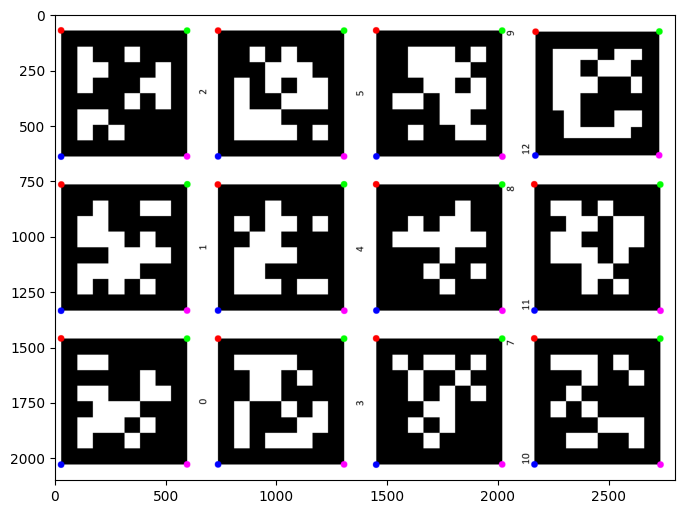

In [49]:
img = cv2.imread('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/ros-apriltag-board.png', cv2.IMREAD_GRAYSCALE)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
print(img.shape)
#april_sample.png
detector = apriltag.Detector()
base_result = detector.detect(img)

blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]

colors = [blue, red, greed, purple]
num_detection = len(base_result)

img_plot = cv2.imread('/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/ros-apriltag-board.png')
img_plot = cv2.rotate(img_plot, cv2.ROTATE_90_COUNTERCLOCKWISE)

for i_tag in range(num_detection):
    
    one_tag = base_result[i_tag]
    one_tagname = base_result[i_tag].tag_family
    one_corners = base_result[i_tag].corners
    
    for i_corner in range(4):
        img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 30)

fig=plt.figure(figsize=(8,12), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_plot[:,:,::-1])

assert len(base_result) == 12, 'detector result must be 12'

# LOAD ORIGIN IMAGE

In [50]:
origin_camera_image_dir = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/extrinsic_images/left_22240376_right_22206080_worldOrigin/left_22240376/2224.jpg'

origin_camera_image_dir = '/home/hict/yeonkunlee/MULTIVIEW_CAL_HICT/cal_image/cam_00_world_origin.png'

In [51]:
options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)

origin_image = cv2.imread(origin_camera_image_dir)
origin_image_gray = cv2.cvtColor(origin_image, cv2.COLOR_BGR2GRAY)

detector_result = detector.detect(origin_image_gray)

In [52]:
origin_image_plot = copy.deepcopy(origin_image)

for _tag in detector_result:
    corners = _tag.corners
    corners = corners
    centers = _tag.center
    centers = centers
    cv2.line(origin_image_plot, (int(corners[0, 0]), int(corners[0, 1])),
             (int(corners[1, 0]), int(corners[1, 1])), (0, 255, 0), 2)
    cv2.line(origin_image_plot, (int(corners[1, 0]), int(corners[1, 1])),
             (int(corners[2, 0]), int(corners[2, 1])), (0, 255, 0), 2)
    cv2.line(origin_image_plot, (int(corners[2, 0]), int(corners[2, 1])),
             (int(corners[3, 0]), int(corners[3, 1])), (0, 255, 0), 2)
    cv2.line(origin_image_plot, (int(corners[3, 0]), int(corners[3, 1])),
             (int(corners[0, 0]), int(corners[0, 1])), (0, 255, 0), 2)

    cv2.circle(origin_image_plot, (int(centers[0]), int(centers[1])),
               2, (0, 255, 0), 2)
    # draw the tag id. int type
    cv2.putText(origin_image_plot, str(_tag.tag_id), (int(centers[0]), int(centers[1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

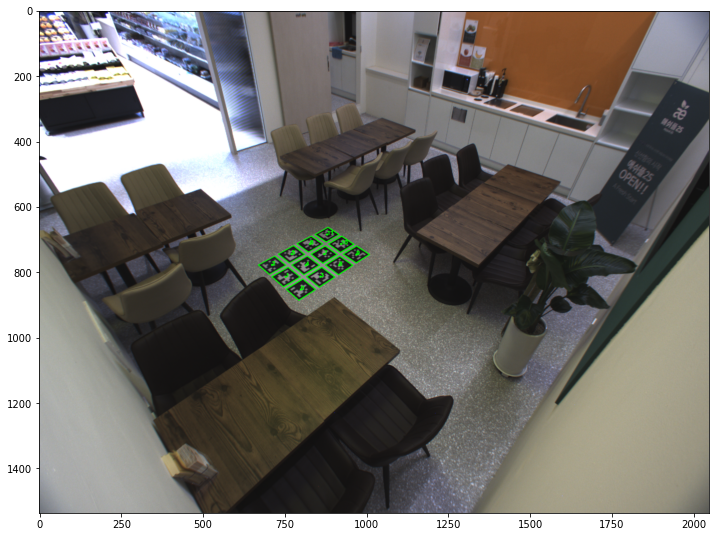

In [53]:
figsize = (12, 12)
plt.figure(figsize=figsize)
plt.imshow(origin_image_plot[:,:,::-1])

In [54]:
assert len(detector_result) == 12, 'detector result must be 12'

# SOLVEPNP

In [55]:
detected_tag = []
detected_2d = []

for i_tag in range(len(detector_result)):
    one_tag = detector_result[i_tag]
    one_tagname = one_tag.tag_id
    one_corners = one_tag.corners
    detected_tag.append(one_tagname)
    detected_2d.append(one_corners)

apriltag_objp = []
for i_tag in range(len(detector_result)):
    base_one_tag = base_result[i_tag]
    base_one_corners = base_one_tag.corners
    apriltag_objp.append(base_one_corners)

apriltag_objp = np.array(apriltag_objp)
apriltag_objp = apriltag_objp.reshape(-1,2)
_zeros = np.zeros([apriltag_objp.shape[0],1])
apriltag_3d_objp = np.concatenate([apriltag_objp, _zeros], axis=1)
apriltag_3d_objp *= apriltag_one_side_length/(597.00000089 - 27.99999955) # synthesized 3D object points

detected_2d = np.array(detected_2d).reshape(-1, 2)

In [56]:
origin_success, origin_rvec, origin_tvec = cv2.solvePnP(apriltag_3d_objp, detected_2d, origin_cam_mtx, origin_cam_dist, 0)

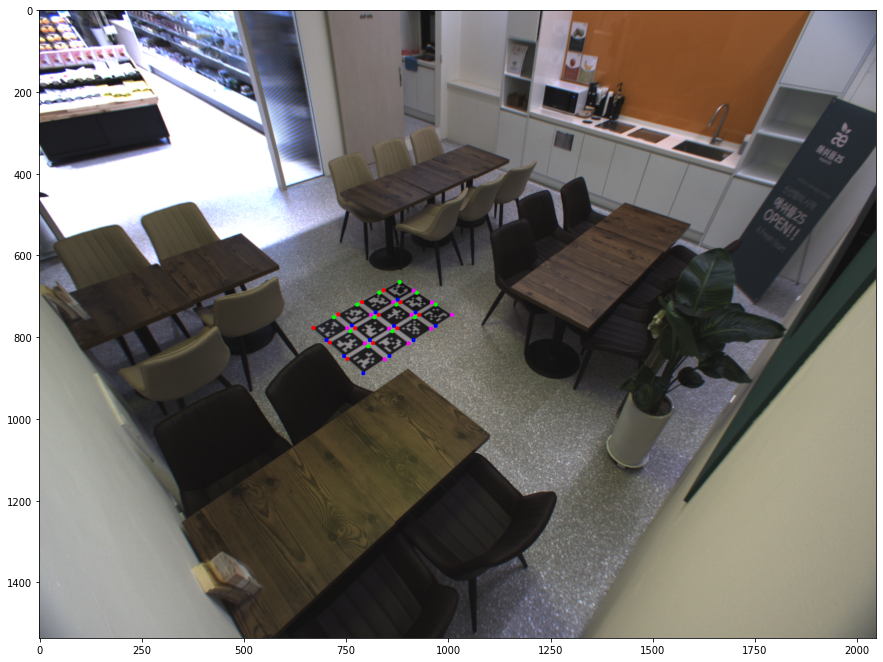

In [57]:
# project 3d points to 2d points
projected_2d_optimized = cv2.projectPoints(apriltag_3d_objp, origin_rvec, origin_tvec, origin_cam_mtx, origin_cam_dist)[0].reshape(-1,2)

# plot detected 2d points of apriltag
origin_image_plot = copy.deepcopy(origin_image)
# plot the detected 2d points
figsize = (15, 15)
plt.figure(figsize=figsize)
# plt.scatter(detected_2d[:,0], detected_2d[:,1], c='r', s=5)
for point_i in range(len(detected_2d)):
    # plt.scatter(detected_2d[point_i, 0], detected_2d[point_i, 1], c=colors[point_i%4], s=5)
    origin_image_plot = cv2.circle(origin_image_plot, (int(projected_2d_optimized[point_i, 0]),int(projected_2d_optimized[point_i, 1])), 0, colors[point_i%4], 10)

    # if point_i == 3:
    #     break

plt.imshow(origin_image_plot[:,:,::-1])

# SAVE FINAL RESULT

In [58]:
bundle_result = np.load(bundle_result_savename)

rvec_cam_0 = np.zeros([3,1])
tvec_cam_0 = np.zeros([3,1]) # FIX FIRST CAMERA IDENTITY

rvec_cam_1 = bundle_result[6:9].reshape(3,1)
tvec_cam_1 = bundle_result[9:12].reshape(3,1)
rvec_cam_2 = bundle_result[12:15].reshape(3,1)
tvec_cam_2 = bundle_result[15:18].reshape(3,1)
rvec_cam_3 = bundle_result[18:21].reshape(3,1)
tvec_cam_3 = bundle_result[21:24].reshape(3,1)
rvec_cam_4 = bundle_result[24:27].reshape(3,1)
tvec_cam_4 = bundle_result[27:30].reshape(3,1)
rvec_cam_5 = bundle_result[30:33].reshape(3,1)
tvec_cam_5 = bundle_result[33:36].reshape(3,1)
mtx_0 = get_K(bundle_result[36:40])
dist_0 = bundle_result[40:45].reshape(1,5)
mtx_1 = get_K(bundle_result[45:49])
dist_1 = bundle_result[49:54].reshape(1,5)
mtx_2 = get_K(bundle_result[54:58])
dist_2 = bundle_result[58:63].reshape(1,5)
mtx_3 = get_K(bundle_result[63:67])
dist_3 = bundle_result[67:72].reshape(1,5)
mtx_4 = get_K(bundle_result[72:76])
dist_4 = bundle_result[76:81].reshape(1,5)
mtx_5 = get_K(bundle_result[81:85])
dist_5 = bundle_result[85:90].reshape(1,5)

In [59]:
np.save(os.path.join(bundle_root, cam_serial_list[0]+'_K.npy'), mtx_0)
np.save(os.path.join(bundle_root, cam_serial_list[0]+'_dist.npy'), dist_0)
np.save(os.path.join(bundle_root, cam_serial_list[1]+'_K.npy'), mtx_1)
np.save(os.path.join(bundle_root, cam_serial_list[1]+'_dist.npy'), dist_1)
np.save(os.path.join(bundle_root, cam_serial_list[2]+'_K.npy'), mtx_2)
np.save(os.path.join(bundle_root, cam_serial_list[2]+'_dist.npy'), dist_2)
np.save(os.path.join(bundle_root, cam_serial_list[3]+'_K.npy'), mtx_3)
np.save(os.path.join(bundle_root, cam_serial_list[3]+'_dist.npy'), dist_3)
np.save(os.path.join(bundle_root, cam_serial_list[4]+'_K.npy'), mtx_4)
np.save(os.path.join(bundle_root, cam_serial_list[4]+'_dist.npy'), dist_4)
np.save(os.path.join(bundle_root, cam_serial_list[5]+'_K.npy'), mtx_5)
np.save(os.path.join(bundle_root, cam_serial_list[5]+'_dist.npy'), dist_5)


In [60]:
def get_RT_world_from_rtvec(_rvec=[.0,.0,.0], _tvec=[.0,.0,.0]):
    _R_c, _ = cv2.Rodrigues(_rvec)
    _R_w = _R_c.transpose()
    _T_c = _tvec
    _T_w = -np.matmul(_R_w, _T_c)
    return _R_w, _T_w

In [61]:
R_origin_cam = cv2.Rodrigues(origin_rvec)[0]
T_origin_cam = np.array([origin_tvec]).reshape(3,1)

R_origin_world = R_origin_cam.transpose()
T_origin_world = -np.matmul(R_origin_world, T_origin_cam)

In [62]:
R_world_cam_0, T_world_cam_0 = get_RT_world_from_rtvec(rvec_cam_0, tvec_cam_0)
R_world_cam_1, T_world_cam_1 = get_RT_world_from_rtvec(rvec_cam_1, tvec_cam_1)
R_world_cam_2, T_world_cam_2 = get_RT_world_from_rtvec(rvec_cam_2, tvec_cam_2)
R_world_cam_3, T_world_cam_3 = get_RT_world_from_rtvec(rvec_cam_3, tvec_cam_3)
R_world_cam_4, T_world_cam_4 = get_RT_world_from_rtvec(rvec_cam_4, tvec_cam_4)
R_world_cam_5, T_world_cam_5 = get_RT_world_from_rtvec(rvec_cam_5, tvec_cam_5)

R_world_cam_0 = np.matmul(R_origin_world, R_world_cam_0)
T_world_cam_0 = T_origin_world + np.matmul(R_origin_world, T_world_cam_0)
R_world_cam_1 = np.matmul(R_origin_world, R_world_cam_1)
T_world_cam_1 = T_origin_world + np.matmul(R_origin_world, T_world_cam_1)
R_world_cam_2 = np.matmul(R_origin_world, R_world_cam_2)
T_world_cam_2 = T_origin_world + np.matmul(R_origin_world, T_world_cam_2)
R_world_cam_3 = np.matmul(R_origin_world, R_world_cam_3)
T_world_cam_3 = T_origin_world + np.matmul(R_origin_world, T_world_cam_3)
R_world_cam_4 = np.matmul(R_origin_world, R_world_cam_4)
T_world_cam_4 = T_origin_world + np.matmul(R_origin_world, T_world_cam_4)
R_world_cam_5 = np.matmul(R_origin_world, R_world_cam_5)
T_world_cam_5 = T_origin_world + np.matmul(R_origin_world, T_world_cam_5)

rvec_cam_0, tvec_cam_0 = from_world_to_cam_coord(R_world_cam_0, T_world_cam_0)
rvec_cam_1, tvec_cam_1 = from_world_to_cam_coord(R_world_cam_1, T_world_cam_1)
rvec_cam_2, tvec_cam_2 = from_world_to_cam_coord(R_world_cam_2, T_world_cam_2)
rvec_cam_3, tvec_cam_3 = from_world_to_cam_coord(R_world_cam_3, T_world_cam_3)
rvec_cam_4, tvec_cam_4 = from_world_to_cam_coord(R_world_cam_4, T_world_cam_4)
rvec_cam_5, tvec_cam_5 = from_world_to_cam_coord(R_world_cam_5, T_world_cam_5)


In [63]:
Tr_trans_0 = calculate_Tr(rvec_np=rvec_cam_0, tvec_np=tvec_cam_0) # zeros.
np.save(os.path.join(bundle_root, cam_serial_list[0]+'_Tr_rotated.npy'), Tr_trans_0)

Tr_trans_1 = calculate_Tr(rvec_np=rvec_cam_1, tvec_np=tvec_cam_1)
np.save(os.path.join(bundle_root, cam_serial_list[1]+'_Tr_rotated.npy'), Tr_trans_1)

Tr_trans_2 = calculate_Tr(rvec_np=rvec_cam_2, tvec_np=tvec_cam_2)
np.save(os.path.join(bundle_root, cam_serial_list[2]+'_Tr_rotated.npy'), Tr_trans_2)

Tr_trans_3 = calculate_Tr(rvec_np=rvec_cam_3, tvec_np=tvec_cam_3)
np.save(os.path.join(bundle_root, cam_serial_list[3]+'_Tr_rotated.npy'), Tr_trans_3)

Tr_trans_4 = calculate_Tr(rvec_np=rvec_cam_4, tvec_np=tvec_cam_4)
np.save(os.path.join(bundle_root, cam_serial_list[4]+'_Tr_rotated.npy'), Tr_trans_4)

Tr_trans_5 = calculate_Tr(rvec_np=rvec_cam_5, tvec_np=tvec_cam_5)
np.save(os.path.join(bundle_root, cam_serial_list[5]+'_Tr_rotated.npy'), Tr_trans_5)